In [1]:
from keras.optimizers import Adam
import tensorflow as tf
from tensorflow import keras
import os
import tempfile
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from tensorflow.keras.regularizers import l1
from tensorflow.keras.regularizers import l2
from tensorflow.keras.regularizers import L1L2
from keras.optimizers import Adam
from sklearn.preprocessing import binarize


Using TensorFlow backend.


In [2]:
class PreProcessing():
    def __init__(self, list_data, target):
        self.target = target
        self.train_sample = list_data[0].copy()
        self.test_sample = list_data[1].copy()
        self.test_sample = self.shuffle_data(self.test_sample)
        self.test_sample, self.val_sample = self._split_test_data()
        self.train_label = self._create_target(self.train_sample)
        self.test_label = self._create_target(self.test_sample)
        self.val_label = self._create_target(self.val_sample)
        self.process_data()
        
    def process_data(self):
        self._print_summary()
        self._training_sets_array()
        self._scale_data()
        
    def shuffle_data(self, dataset):
        return shuffle(dataset).reset_index(drop=True)
    
    def _split_test_data(self):
        return train_test_split(self.test_sample, test_size=.2)
        
    def _create_target(self, dataset):
        return np.array(dataset.pop(self.target))
        
    def _print_summary(self):
        print("Training data shape:", self.train_sample.shape)
        print("Testing data shape:", self.test_sample.shape)
        print("Validation data shape:", self.val_sample.shape)
        print("train_label length:", self.train_label.shape[0])
        print("test_label length:", self.test_label.shape[0])
        print("val_label length:", self.val_label.shape[0])
        
    def _training_sets_array(self):
        self.train_sample = np.array(self.train_sample)
        self.test_sample = np.array(self.test_sample)
        self.val_sample = np.array(self.val_sample)
        
    def _scale_data(self):
        scaler = StandardScaler()
        self.train_sample = scaler.fit_transform(self.train_sample)
        self.test_sample = scaler.transform(self.test_sample)
        self.val_sample = scaler.transform(self.val_sample)


In [3]:
class CreateModel():
    '''creates the model
    '''
    def __init__(self):
        self.filepath_chkpt = './cp.ckpt/'
        self.train_sample = pp.train_sample
        self.train_label = pp.train_label
        self.test_sample = pp.test_sample
        self.test_label = pp.test_label
        self.val_sample = pp.val_sample
        self.val_label = pp.val_label
    
    def _checkpoint_path(self):
        checkpoint_path = "./cp.ckpt/cp-{epoch:04d}.ckpt"
        return checkpoint_path
    
    def _define_checkpoint(self):
        checkpoint_path = self._checkpoint_path()
        cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, 
                                                         monitor='val_auc', 
                                                         verbose=1,
                                                         save_best_only=False, 
                                                         save_weights_only=True,
                                                         mode='max',
                                                         save_freq='epoch')
        return cp_callback
    
    def create_model(self, model, metrics, lr, loss):
        'ingests and compiles model'
        model.compile(optimizer=keras.optimizers.Adam(lr=lr), 
                      loss=loss, metrics=metrics)
        return model
    
    def fit_model(self, model, epochs, fit_model=False):
        if fit_model:
            model = self._save_weights(model)
            model.fit(self.train_sample, self.train_label, 
                      validation_data=(self.val_sample, self.val_label), 
                      batch_size=20, epochs=epochs, shuffle=True, verbose=2, 
                      workers=16, use_multiprocessing=True,
                      callbacks=[cp_callback])
            
        if ~fit_model:
            print("fit_model method is set to false.")
    
    def _save_weights(self, model):
        checkpoint_path = self._checkpoint_path()
        model.save_weights(checkpoint_path.format(epoch=0))
        return model


In [4]:
class TuneThreshold():
    '''Fine tuning each epoch
    '''
    def __init__(self):
        self.current_thres = []
        self.top_score = []
        self.df_all_results = pd.DataFrame()
        self.best_chkpt = []
        self.best_threshold = []
        
    def tune_threshold(self, model):
        y_pred = model.predict(pp.test_sample, batch_size=10, verbose=0)
        
        list_threshold = [.05, .1, .15, .2, .25, .3, .35, .4, .45, 
                          .5, .55, .6, .65, .7, .75, .8, .85, .9]
        self._tune_thres_methods(list_threshold, y_pred)
        list_tune_thres = self._fine_tune_thres()
        self._tune_thres_methods(list_tune_thres, y_pred)
        list_tune_thres = self._fine_tune_thres_2()
        self._tune_thres_methods(list_tune_thres, y_pred)        
        self._create_results_df()
        self._save_best_thres()
    
        
    def _tune_thres_methods(self, list_threshold, y_pred):
        list_auc_score = self._calc_thres_score(list_threshold, y_pred)        
        df_results = self._create_df_results(list_auc_score, list_threshold)
        self._calc_best_score(df_results)
        
    def _calc_thres_score(self, list_threshold, y_pred):
        list_auc_score = []
        for thres in list_threshold:
            y_pred_class = binarize(y_pred, thres)
            fpr, tpr, thresholds = roc_curve(pp.test_label, 
                                             y_pred_class, 
                                             pos_label=1)
            auc_score = auc(fpr, tpr)
            list_auc_score.append(auc_score)
        return list_auc_score
    
    def _create_df_results(self, list_auc_score, list_threshold):
        col_thres = pd.Series(list_threshold, name='current_thres')
        col_auc = pd.Series(list_auc_score, name='auc_score')
        df_results = pd.concat([col_thres, col_auc], axis=1)
        return df_results
    
    def _calc_best_score(self, df_results):
        val_max_auc = df_results.auc_score.max()
        df_max_auc = df_results[df_results.auc_score == val_max_auc]
        df_max_auc_index = df_max_auc.index[0]
        self.current_thres = df_results.loc[df_max_auc_index, 'current_thres']
        self.top_score = val_max_auc 
    
    def _fine_tune_thres(self):
        list_tune_thres = []
        temp_val_neg = self.current_thres
        temp_val_pos = self.current_thres
        for val in range(0,5):
            temp_val_neg = temp_val_neg - .01
            temp_val_pos = temp_val_pos + .01
            list_tune_thres.append(round(temp_val_neg, 2))
            list_tune_thres.append(round(temp_val_pos, 2))
        list_tune_thres.append(round(self.current_thres, 2))    
        list_tune_thres.sort()
        return list_tune_thres
    
    def _fine_tune_thres_2(self):
        list_tune_thres = []
        temp_val_neg = self.current_thres
        temp_val_pos = self.current_thres
        for val in range(0,5):
            temp_val_neg = temp_val_neg - .001
            temp_val_pos = temp_val_pos + .001
            list_tune_thres.append(round(temp_val_neg, 3))
            list_tune_thres.append(round(temp_val_pos, 3))
        list_tune_thres.append(round(self.current_thres, 3))    
        list_tune_thres.sort()
        return list_tune_thres
    
    def _create_results_df(self):
        col_chkpt = pd.Series(sc.chkpt_num, name='chkpt_epoch')
        col_thres = pd.Series(self.current_thres, name='best_threshold')
        col_auc = pd.Series(self.top_score, name='auc_score')
        df_temp = pd.concat([col_chkpt, col_thres, col_auc], axis=1)
        print(df_temp)
        self.df_all_results = pd.concat([self.df_all_results, df_temp], axis=0)
        
    def _save_best_thres(self):
        dataset = self.df_all_results.copy()
        val_best_auc = dataset.auc_score.max()
        val_best_chkpt = dataset[dataset.auc_score==val_best_auc].chkpt_epoch
        val_best_thres = dataset[dataset.auc_score==val_best_auc].best_threshold
        self.best_chkpt = val_best_chkpt[0]
        self.best_threshold = val_best_thres[0]


In [5]:
class ScoreCheckpoints():
    '''Loading and testing each checkpoint
    
    '''
    def __init__(self):
        self.checkpoint_path = './cp.ckpt/'
        self.list_auc_score = []
        self.list_epoch = []
        self.chkpt_num = []
    
    def create_chkpt_list(self):
        list_checkpoints = []
        for file in os.listdir(self.checkpoint_path):
            val_checkpoint = file[0:12]
            if file[0:3]=='cp-' and val_checkpoint not in list_checkpoints:
                list_checkpoints.append(val_checkpoint)
        list_checkpoints.sort()
        return list_checkpoints
    
    def score_chkpts(self):
        list_checkpoints = self.create_chkpt_list()
        list_epoch = []
        for chkpt in list_checkpoints[67:68]: # setting 66:67 for fast testing
            filepath_chkpt = self.checkpoint_path + chkpt
            model = mod.create_model(MODEL_SEQ, METRICS, LR, LOSS)
            model.load_weights(filepath_chkpt)
            rounded_predictions = model.predict_classes(pp.test_sample, batch_size=10, verbose=0)
            auc_score = self._calc_chkpt_score(rounded_predictions)
            self.chkpt_num = chkpt[3:7]
            tt.tune_threshold(model)
            self._plot_auc_scores()
        # printing final dataframe results
        print(tt.df_all_results)
        self._plot_auc_scores()
            
    def _calc_chkpt_score(self, rounded_predictions):
        fpr, tpr, thresholds = roc_curve(pp.test_label, rounded_predictions, pos_label=1)
        # cm = confusion_matrix(pp.test_label, rounded_predictions) #not needed for now 
        auc_score = auc(fpr, tpr)
        self.list_auc_score.append(auc_score)
        return auc_score
    
    def _plot_auc_scores(self):
        list_epoch = []
        for val in range(1, len(self.list_auc_score) + 1):
            list_epoch.append(val)
        plt.plot(list_epoch, self.list_auc_score)
        plt.title("Checkpoint Versus AUC Score")
        plt.ylabel("AUC Score")
        plt.xlabel("Checkpoint / Epoch")


In [6]:
class SaveModel():
    def __init__(self):
        self.chkpt_file_path = self._create_file_path()
        self.saved_model_file_path = mod.filepath_chkpt + 'saved_model/'
    
    def _create_file_path(self):
        chkpt_file_path = mod.filepath_chkpt + 'cp-' + tt.best_chkpt + '.ckpt'
        return chkpt_file_path
    
    def save_best_model(self):
        model = self._load_model_weights()
        save_model_file_path = mod.filepath_chkpt + 'saved_model/' #delete this after fixing other bug
        tf.saved_model.save(model, self.saved_model_file_path)
    
    def _load_model_weights(self):
        model = mod.create_model(MODEL_SEQ, METRICS, LR, LOSS)
        model.load_weights(self.chkpt_file_path)
        return model
        
    def load_saved_model(self, summary=False):
        model = tf.keras.models.load_model(self.saved_model_file_path)
        if summary:
            print('\n')
            print(model.summary())
            print('\n')
        return model

    def predict_binarize(self, model, test_data):
        y_pred = model.predict(pp.test_sample, batch_size=10, verbose=0)
        y_pred_class = binarize(y_pred, tt.best_threshold)
        fpr, tpr, thresholds = roc_curve(pp.test_label, y_pred_class, pos_label=1)
        auc_score = auc(fpr, tpr)
        print('\nauc for best model and best threshold:', auc_score)
        return y_pred_class


### Load Data

In [7]:
filepath_data = '/Users/krahman/work/tutorials/tensorflow_classification/data/'

df_raw = pd.read_csv(filepath_data + 'mod_x_train.csv').drop('Unnamed: 0', axis=1) #del once finished testing

train_sample = pd.read_csv(filepath_data + 'mod_x_train.csv').drop('Unnamed: 0', axis=1)
train_label = pd.read_csv(filepath_data + 'mod_y_train.csv').drop('Unnamed: 0', axis=1)
train_sample = pd.concat([train_sample, train_label], axis=1)
test_sample = pd.read_csv(filepath_data + 'mod_x_test.csv').drop('Unnamed: 0', axis=1)
test_label = pd.read_csv(filepath_data + 'mod_y_test.csv').drop('index', axis=1)
test_sample = pd.concat([test_sample, test_label], axis=1)

target = '0'

list_data = [train_sample, test_sample]


### Instantiate PreProcessing Class

In [8]:
pp = PreProcessing(list_data, target)

Training data shape: (190000, 233)
Testing data shape: (47243, 233)
Validation data shape: (11811, 233)
train_label length: 190000
test_label length: 47243
val_label length: 11811


### Instantiate CreateModel Class

In [9]:
mod = CreateModel()

### Defining Neural Network Layers

In [10]:
DF_TRAIN = pp.train_sample

neg, pos = np.bincount(train_sample[target])
initial_bias = np.log([pos/neg])
OUTPUT_BIAS = tf.keras.initializers.Constant(initial_bias)
LOSS = keras.losses.BinaryCrossentropy()
LR = .0001
METRICS = [keras.metrics.AUC(name='auc'),
           keras.metrics.FalsePositives(name='fp'),
           keras.metrics.FalseNegatives(name='fn')]

MODEL_SEQ = keras.Sequential([keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001), input_shape=(DF_TRAIN.shape[-1],)),
                              keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
                              keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
                              keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
                              keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
                              keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
                              keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
                              keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
                              keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.0001)),
                              keras.layers.Dropout(.5),
                              keras.layers.Dense(1, activation='sigmoid', bias_initializer=OUTPUT_BIAS)])

# MODEL_SEQ = keras.Sequential([keras.layers.Dense(16, activation='relu', kernel_regularizer=l2(0.0001), input_shape=(DF_TRAIN.shape[-1],)),
#                           keras.layers.Dense(16, activation='relu', kernel_regularizer=l2(0.0001)),
#                           keras.layers.Dropout(.5),
#                           keras.layers.Dense(1, activation='sigmoid', bias_initializer=OUTPUT_BIAS)])


### Creating Model

In [11]:
model = mod.create_model(MODEL_SEQ, METRICS, LR, LOSS)

### Fitting Model

In [12]:
mod.fit_model(model, epochs=100, fit_model=False) #comment out until next fitting

fit_model method is set to false.


### Instantiate TuneThreshold Class

In [13]:
tt = TuneThreshold()

### Instantiate ScoreCheckpoints Class

In [14]:
sc = ScoreCheckpoints()

### Score Checkpoints

  chkpt_epoch  best_threshold  auc_score
0        0067           0.168   0.867784
  chkpt_epoch  best_threshold  auc_score
0        0067           0.168   0.867784


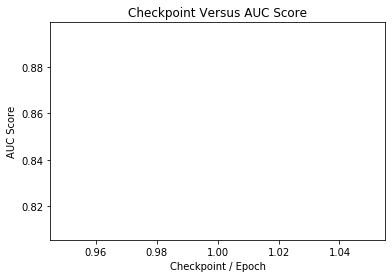

In [15]:
list_checkpoints = sc.create_chkpt_list()
sc.score_chkpts()

In [16]:
sm = SaveModel()
sm.save_best_model()
model_1 = sm.load_saved_model(summary=True)
y_pred = sm.predict_binarize(model_1, pp.test_sample)
y_pred

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./cp.ckpt/saved_model/assets


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               59904     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_5 (Dense)              (None, 256) 

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)